## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [2]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/leeds_msc_ocom5300m_project/results/"

Mounted at /content/drive


Importing required libraries

In [4]:
import os, gc
import random, math
import shutil
import time, datetime
from thop import vision, profile, clever_format
from flopth import flopth
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cpu


Device (CPU/GPU) available to use.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cpu


Setting up logger and directories

In [6]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/leeds_msc_ocom5300m_project/results/


## Base CapsNet accuracy and loss for different CCM alpha values

CapsNet Model used: C=16, D=12

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

alpha001_basecapsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_ccm_model_Epoch30_of_30.pt', map_location=device)
alpha005_basecapsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'alpha005/'+'Trained_base_capsnet_cifar10_ccm_model_Epoch15_of_15.pt', map_location=device)
alpha0001_basecapsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'alpha0001/'+'Trained_base_capsnet_cifar10_ccm_model_Epoch15_of_15.pt', map_location=device)
alpha0005_basecapsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'alpha0005/'+'Trained_base_capsnet_cifar10_ccm_model_Epoch15_of_15.pt', map_location=device)
alpha010_basecapsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'alpha010/'+'Trained_base_capsnet_cifar10_ccm_model_Epoch15_of_15.pt', map_location=device)

models = [alpha010_basecapsnet_ccm_model,
          alpha001_basecapsnet_ccm_model,
          alpha005_basecapsnet_ccm_model,
          alpha0001_basecapsnet_ccm_model,
          alpha0005_basecapsnet_ccm_model]

ccm_loss_alpha = ['0.1', '0.01', '0.05', '0.001', '0.005']

avg_losses = []
avg_accuracies = []

n_epochs = 15

for indx, model in enumerate(models):
    avg_losses.append(model['epoch_loss'][:,:n_epochs][1].mean().round(4))
    avg_accuracies.append(model['epoch_accuracy'][:,:n_epochs][1].mean().round(3))

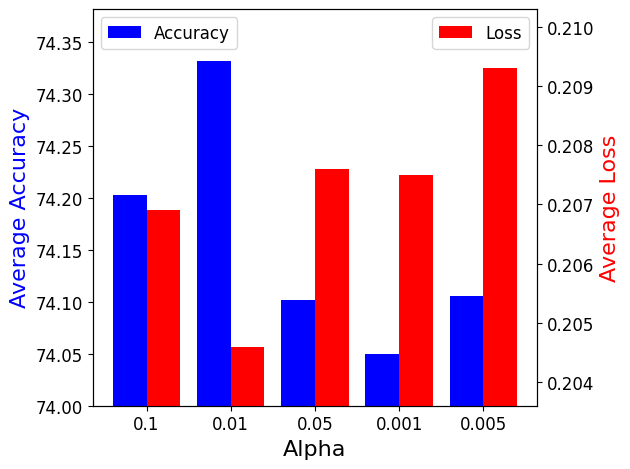

In [ ]:
fig, ax = plt.subplots()

x = np.arange(len(ccm_loss_alpha))
width = 0.2

ax.bar(x-width, avg_accuracies, label='Accuracy', width=.4, color='blue')
ax.set_ylim(min(avg_accuracies) - 0.05, max(avg_accuracies) + 0.05, auto=True)
ax.set_ylabel('Average Accuracy', color='blue', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax2 = ax.twinx()

ax2.bar(x+width, avg_losses, label='Loss', width=.4, color='red')
ax2.set_ylim(min(avg_losses) - 0.001, max(avg_losses) + 0.001, auto=True)
ax2.set_ylabel('Average Loss', color='red', fontsize = 16)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Alpha', fontsize = 16)
ax.set_xticks(x, ccm_loss_alpha)
# ax.set_title('CapsNet[C=16, D=12] average accuracy and loss for alpha values', fontsize = 16)

ax.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)
fig.tight_layout()
plt.show()

## Base CapsNet [C=16, D=6]

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps6Dim/"

trained_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_62pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_62pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)

models = [trained_base_capsnet_cifar10_model,
          trained_pruned_12pc_base_capsnet_cifar10_model,
          trained_pruned_25pc_base_capsnet_cifar10_model,
          trained_pruned_37pc_base_capsnet_cifar10_model,
          trained_pruned_50pc_base_capsnet_cifar10_model,
          trained_pruned_62pc_base_capsnet_cifar10_model,
          trained_pruned_75pc_base_capsnet_cifar10_model]

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:n_epochs][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :n_epochs][1]

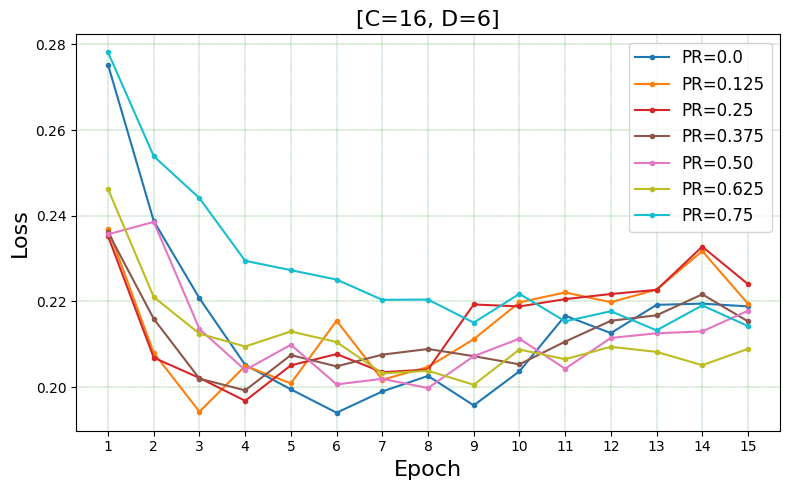

In [ ]:
utils.plot_line_chart(epoch_losses, ['PR=0.0', 'PR=0.125', 'PR=0.25', 'PR=0.375', 'PR=0.50', 'PR=0.625', 'PR=0.75'],
                      'Epoch', 'Loss', '[C=16, D=6]', marker='.', line='-', color_map=plt.cm.tab10)

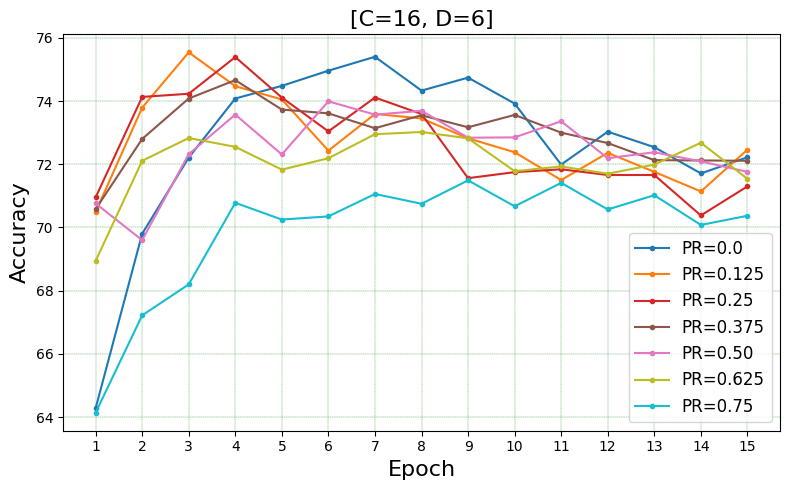

In [ ]:
utils.plot_line_chart(epoch_accuracies, ['PR=0.0', 'PR=0.125', 'PR=0.25', 'PR=0.375', 'PR=0.50', 'PR=0.625', 'PR=0.75'],
                      'Epoch', 'Accuracy', '[C=16, D=6]', marker='.', line='-', color_map=plt.cm.tab10)

## Base CapsNet [C=32, D=8]

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/32Caps8Dim/"

trained_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
trained_pruned_60pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_60pc_base_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)

models = [trained_base_capsnet_cifar10_model,
          trained_pruned_12pc_base_capsnet_cifar10_model,
          trained_pruned_25pc_base_capsnet_cifar10_model,
          trained_pruned_37pc_base_capsnet_cifar10_model,
          trained_pruned_50pc_base_capsnet_cifar10_model,
          trained_pruned_60pc_base_capsnet_cifar10_model,
          trained_pruned_75pc_base_capsnet_cifar10_model]

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:n_epochs][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :n_epochs][1]

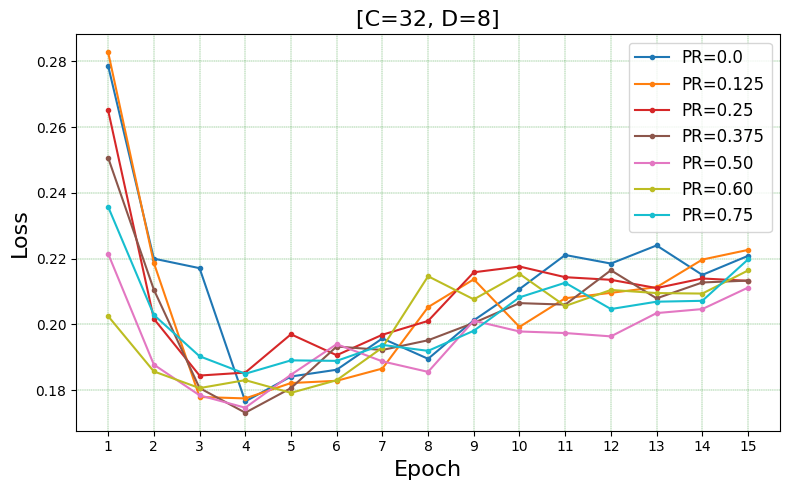

In [ ]:
utils.plot_line_chart(epoch_losses, ['PR=0.0', 'PR=0.125', 'PR=0.25', 'PR=0.375', 'PR=0.50', 'PR=0.60', 'PR=0.75'],
                      'Epoch', 'Loss', '[C=32, D=8]', marker='.', line='-', color_map=plt.cm.tab10)

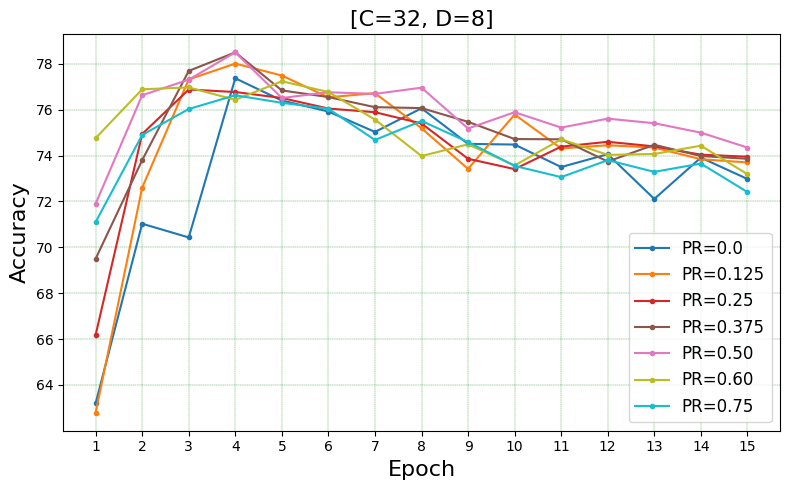

In [ ]:
utils.plot_line_chart(epoch_accuracies, ['PR=0.0', 'PR=0.125', 'PR=0.25', 'PR=0.375', 'PR=0.50', 'PR=0.60', 'PR=0.75'],
                      'Epoch', 'Accuracy', '[C=32, D=8]', marker='.', line='-', color_map=plt.cm.tab10)

## Base CapsNet [C=8, D=12]

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"

trained_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_62pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_62pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)

models = [trained_base_capsnet_cifar10_model,
          trained_pruned_12pc_base_capsnet_cifar10_model,
          trained_pruned_25pc_base_capsnet_cifar10_model,
          trained_pruned_37pc_base_capsnet_cifar10_model,
          trained_pruned_50pc_base_capsnet_cifar10_model,
          trained_pruned_62pc_base_capsnet_cifar10_model,
          trained_pruned_75pc_base_capsnet_cifar10_model]

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:n_epochs][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :n_epochs][1]

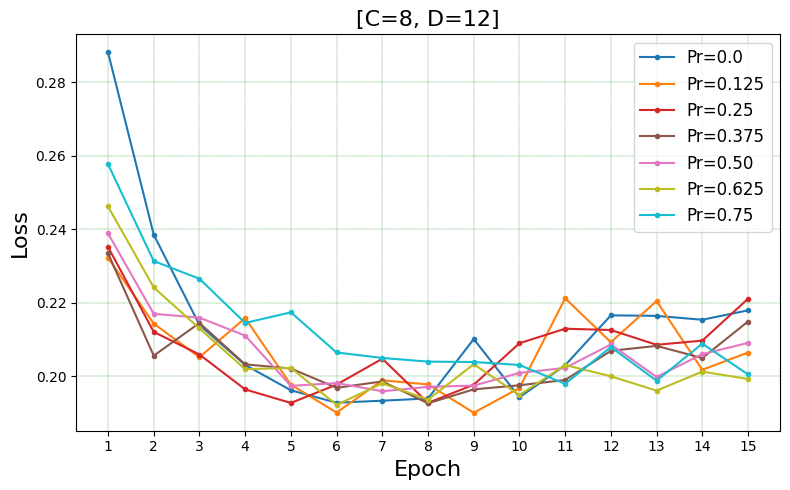

In [ ]:
utils.plot_line_chart(epoch_losses, ['Pr=0.0', 'Pr=0.125', 'Pr=0.25', 'Pr=0.375', 'Pr=0.50', 'Pr=0.625', 'Pr=0.75'],
                      'Epoch', 'Loss', '[C=8, D=12]', marker='.', line='-', color_map=plt.cm.tab10)

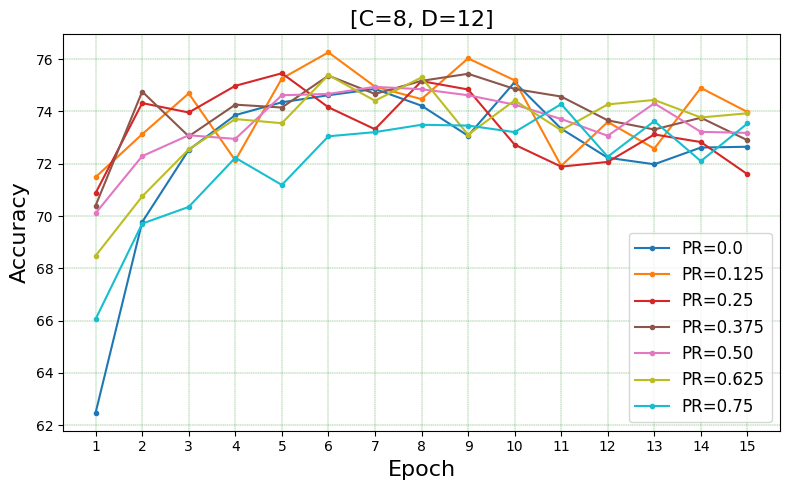

In [ ]:
utils.plot_line_chart(epoch_accuracies, ['PR=0.0', 'PR=0.125', 'PR=0.25', 'PR=0.375', 'PR=0.50', 'PR=0.625', 'PR=0.75'],
                      'Epoch', 'Accuracy', '[C=8, D=12]', marker='.', line='-', color_map=plt.cm.tab10)

## Base CapsNet [C=16, D=12]

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/16Caps12Dim/"

trained_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_62pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_62pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)

models = [trained_base_capsnet_cifar10_model,
          trained_pruned_12pc_base_capsnet_cifar10_model,
          trained_pruned_25pc_base_capsnet_cifar10_model,
          trained_pruned_37pc_base_capsnet_cifar10_model,
          trained_pruned_50pc_base_capsnet_cifar10_model,
          trained_pruned_62pc_base_capsnet_cifar10_model,
          trained_pruned_75pc_base_capsnet_cifar10_model]

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:n_epochs][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :n_epochs][1]

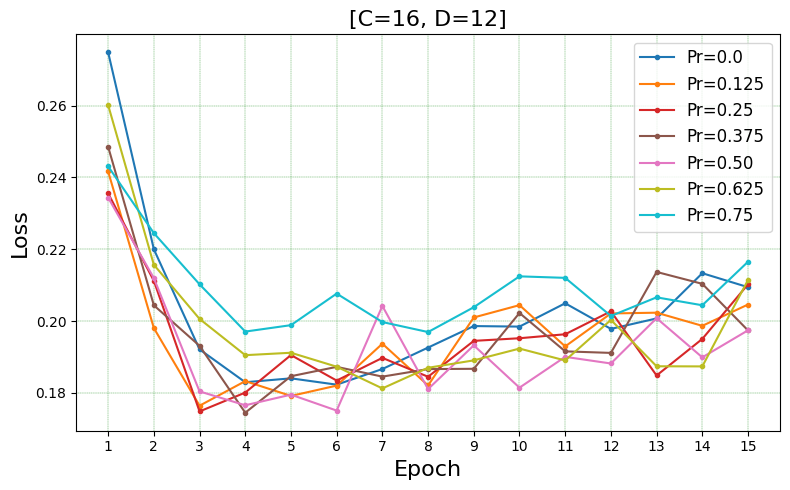

In [ ]:
utils.plot_line_chart(epoch_losses, ['Pr=0.0', 'Pr=0.125', 'Pr=0.25', 'Pr=0.375', 'Pr=0.50', 'Pr=0.625', 'Pr=0.75'],
                      'Epoch', 'Loss', '[C=16, D=12]', marker='.', line='-', color_map=plt.cm.tab10)

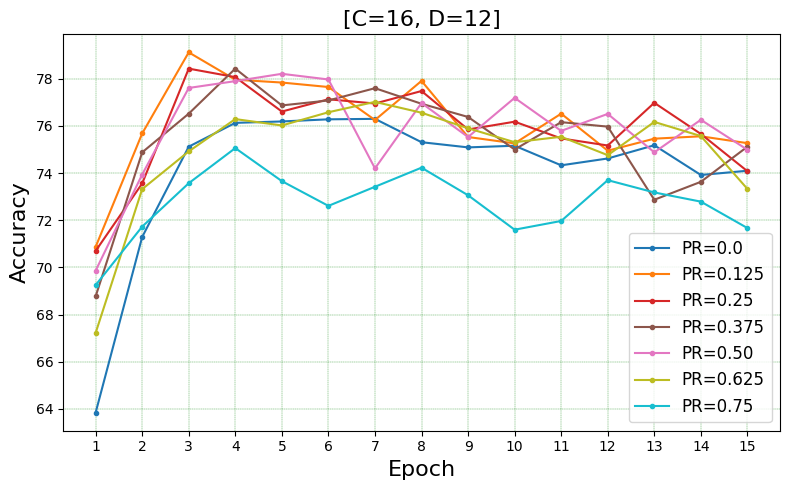

In [ ]:
utils.plot_line_chart(epoch_accuracies, ['PR=0.0', 'PR=0.125', 'PR=0.25', 'PR=0.375', 'PR=0.50', 'PR=0.625', 'PR=0.75'],
                      'Epoch', 'Accuracy', '[C=16, D=12]', marker='.', line='-', color_map=plt.cm.tab10)

## Base CapsNet [C=10, D=8]

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"

trained_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_60pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_60pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)

models = [trained_base_capsnet_cifar10_model,
          trained_pruned_12pc_base_capsnet_cifar10_model,
          trained_pruned_25pc_base_capsnet_cifar10_model,
          trained_pruned_37pc_base_capsnet_cifar10_model,
          trained_pruned_50pc_base_capsnet_cifar10_model,
          trained_pruned_60pc_base_capsnet_cifar10_model,
          trained_pruned_75pc_base_capsnet_cifar10_model]

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:n_epochs][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :n_epochs][1]

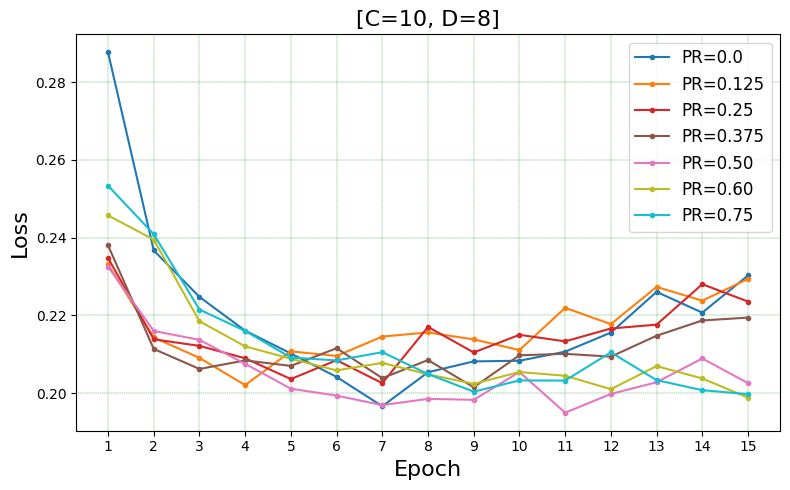

In [ ]:
utils.plot_line_chart(epoch_losses, ['PR=0.0', 'PR=0.125', 'PR=0.25', 'PR=0.375', 'PR=0.50', 'PR=0.60', 'PR=0.75'],
                      'Epoch', 'Loss', '[C=10, D=8]', marker='.', line='-', color_map=plt.cm.tab10)

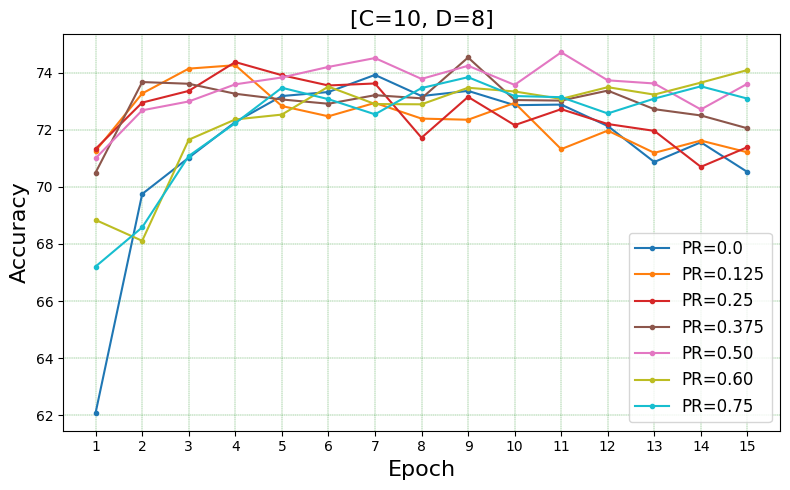

In [ ]:
utils.plot_line_chart(epoch_accuracies, ['PR=0.0', 'PR=0.125', 'PR=0.25', 'PR=0.375', 'PR=0.50', 'PR=0.60', 'PR=0.75'],
                      'Epoch', 'Accuracy', '[C=10, D=8]', marker='.', line='-', color_map=plt.cm.tab10)

## Base CapsNet [C=20, D=8]

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"

trained_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_60pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_60pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)

models = [trained_base_capsnet_cifar10_model,
          trained_pruned_12pc_base_capsnet_cifar10_model,
          trained_pruned_25pc_base_capsnet_cifar10_model,
          trained_pruned_37pc_base_capsnet_cifar10_model,
          trained_pruned_50pc_base_capsnet_cifar10_model,
          trained_pruned_60pc_base_capsnet_cifar10_model,
          trained_pruned_75pc_base_capsnet_cifar10_model]

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:n_epochs][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :n_epochs][1]

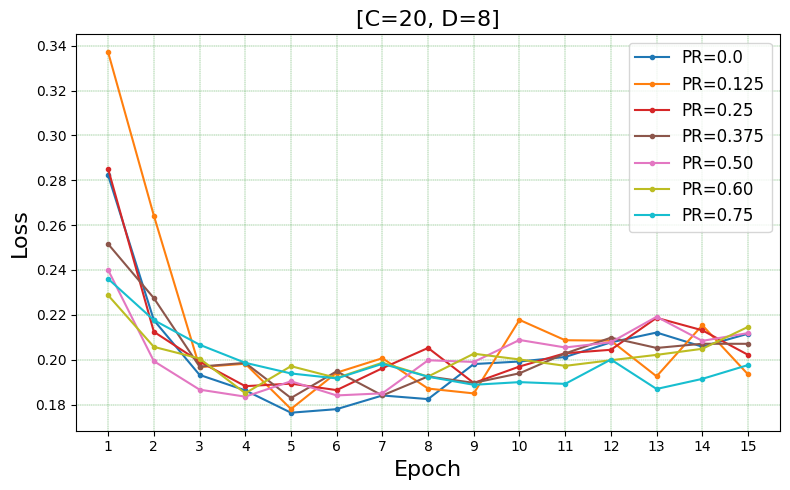

In [ ]:
utils.plot_line_chart(epoch_losses, ['PR=0.0', 'PR=0.125', 'PR=0.25', 'PR=0.375', 'PR=0.50', 'PR=0.60', 'PR=0.75'],
                      'Epoch', 'Loss', '[C=20, D=8]', marker='.', line='-', color_map=plt.cm.tab10)

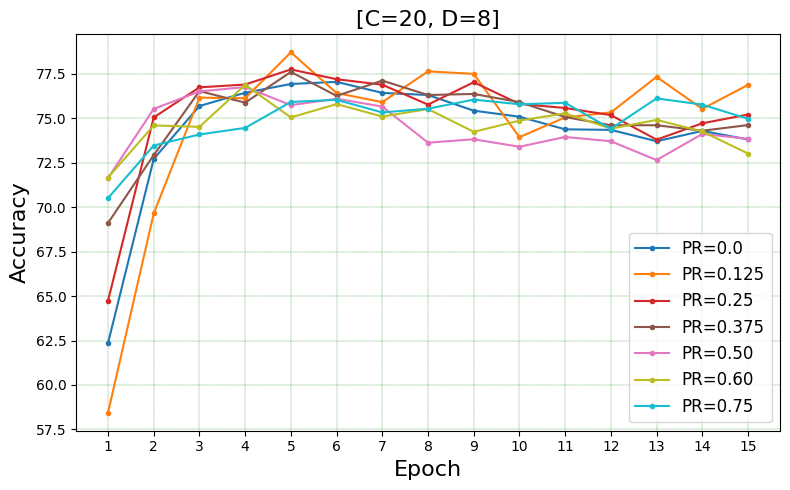

In [ ]:
utils.plot_line_chart(epoch_accuracies,['PR=0.0', 'PR=0.125', 'PR=0.25', 'PR=0.375', 'PR=0.50', 'PR=0.60', 'PR=0.75'],
                      'Epoch', 'Accuracy', '[C=20, D=8]', marker='.', line='-', color_map=plt.cm.tab10)

## Best Accuracies for Pruned CapsNets

In [ ]:
pruned_base_capsnet_C16_D6_cifar10_model = torch.load(TRAIN_DIR+'cifar10/16Caps6Dim/Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt',
                                                      map_location=device)
pruned_base_capsnet_C32_D8_cifar10_model = torch.load(TRAIN_DIR+'cifar10/32Caps8Dim/Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch15_of_15.pt',
                                                      map_location=device)
pruned_base_capsnet_C8_D12_cifar10_model = torch.load(TRAIN_DIR+'cifar10/8Caps12Dim/Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt',
                                                      map_location=device)
pruned_base_capsnet_C16_D12_cifar10_model = torch.load(TRAIN_DIR+'cifar10/16Caps12Dim/Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt',
                                                       map_location=device)
pruned_base_capsnet_C10_D8_cifar10_model = torch.load(TRAIN_DIR+'cifar10/10Caps8Dim/Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt',
                                                      map_location=device)
pruned_base_capsnet_C20_D8_cifar10_model = torch.load(TRAIN_DIR+'cifar10/20Caps8Dim/Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt',
                                                      map_location=device)

models = [pruned_base_capsnet_C10_D8_cifar10_model,
          pruned_base_capsnet_C20_D8_cifar10_model,
          pruned_base_capsnet_C32_D8_cifar10_model,
          pruned_base_capsnet_C16_D6_cifar10_model,
          pruned_base_capsnet_C16_D12_cifar10_model,
          pruned_base_capsnet_C8_D12_cifar10_model]

n_epochs = 15

epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :n_epochs][1]

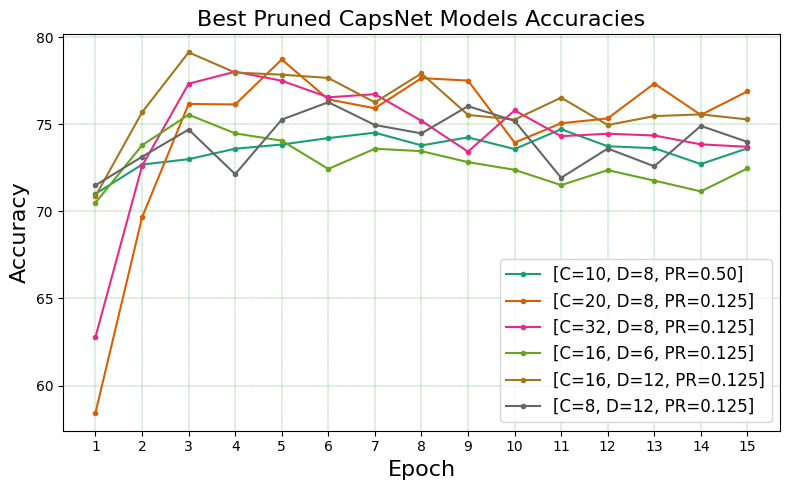

In [ ]:
utils.plot_line_chart(epoch_accuracies, ['[C=10, D=8, PR=0.50]',
                                         '[C=20, D=8, PR=0.125]',
                                         '[C=32, D=8, PR=0.125]',
                                         '[C=16, D=6, PR=0.125]',
                                         '[C=16, D=12, PR=0.125]',
                                         '[C=8, D=12, PR=0.125]'],
                      'Epoch', 'Accuracy', 'Best Pruned CapsNet Models Accuracies', marker='.', line='-',
                      color_map=plt.cm.Dark2)

## CapsNet Intermediate Layers Accuracies

In [ ]:
model_types = ['8Caps12Dim',
               '16Caps12Dim',
               '10Caps8Dim',
               '20Caps8Dim']

model_best_accuracies = np.zeros((len(model_types), 10))

for indx, model in enumerate(model_types):
    TRAIN_MODEL_DIR = TRAIN_DIR+'cifar10/{}/'.format(model)

    accuracies = []

    for i in range(1, 11):
        train_model = torch.load(TRAIN_MODEL_DIR+'Best_multilayer_inter{}_capsnet_cifar10_model.pt'.format(i),
                                 map_location=device)

        accuracies.append(round(train_model['best_top1'], 2))

    model_best_accuracies[indx] = accuracies

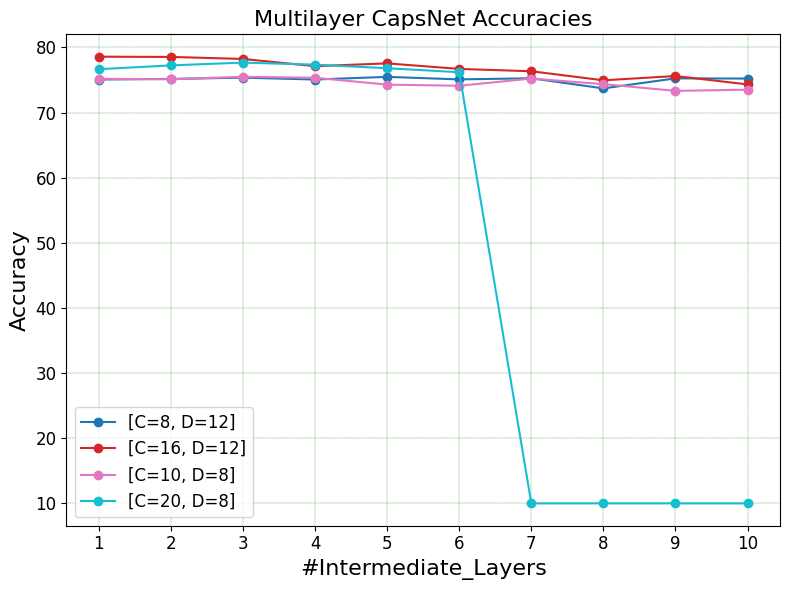

In [ ]:
utils.plot_line_chart(model_best_accuracies, ['[C=8, D=12]','[C=16, D=12]', '[C=10, D=8]', '[C=20, D=8]'],
                      '#Intermediate_Layers', 'Accuracy', 'Multilayer CapsNet Accuracies', marker='o', line='-',
                      color_map=plt.cm.tab10)

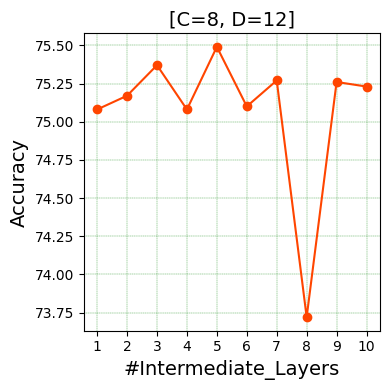

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
xs = np.arange(1, 11)

ax.plot(xs, model_best_accuracies[0], 'o-', color='orangered')

ax.set_xticks(xs)
ax.set_xlabel('#Intermediate_Layers', fontsize = 14)
ax.set_ylabel('Accuracy', fontsize = 14)
ax.set_title('[C=8, D=12]', fontsize = 14)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.25)
fig.tight_layout()

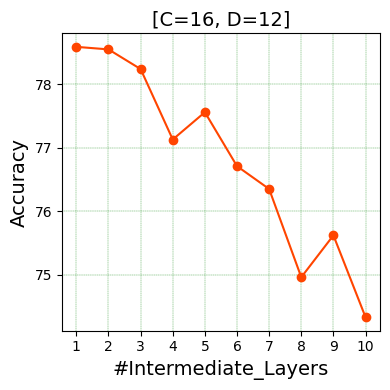

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
xs = np.arange(1, 11)

ax.plot(xs, model_best_accuracies[1], 'o-', color='orangered')

ax.set_xticks(xs)
ax.set_xlabel('#Intermediate_Layers', fontsize = 14)
ax.set_ylabel('Accuracy', fontsize = 14)
ax.set_title('[C=16, D=12]', fontsize = 14)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.25)
fig.tight_layout()

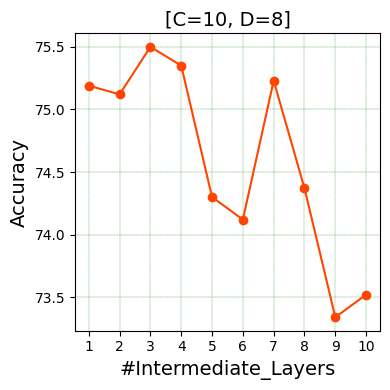

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
xs = np.arange(1, 11)

ax.plot(xs, model_best_accuracies[2], 'o-', color='orangered')

ax.set_xticks(xs)
ax.set_xlabel('#Intermediate_Layers', fontsize = 14)
ax.set_ylabel('Accuracy', fontsize = 14)
ax.set_title('[C=10, D=8]', fontsize = 14)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.25)
fig.tight_layout()

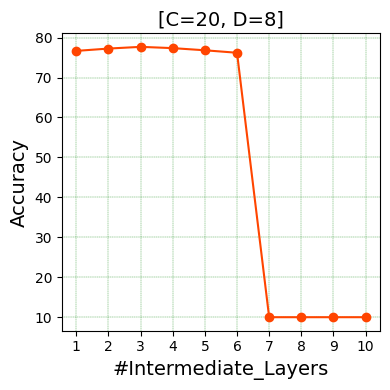

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
xs = np.arange(1, 11)

ax.plot(xs, model_best_accuracies[3], 'o-', color='orangered')

ax.set_xticks(xs)
ax.set_xlabel('#Intermediate_Layers', fontsize = 14)
ax.set_ylabel('Accuracy', fontsize = 14)
ax.set_title('[C=20, D=8]', fontsize = 14)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.25)
fig.tight_layout()

## Vanishing Activations in Multilayer CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+'cifar10/20Caps8Dim/'
n_epochs = 15
inter_layers = 6

epoch_dead_capsules_percent = np.zeros((n_epochs, 1))
epoch_accuracies = np.zeros((n_epochs, 1))

trained_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter{}_capsnet_cifar10_model_Epoch15_of_15.pt'.format(inter_layers),
                   map_location=device)

epoch_accuracies = trained_model['epoch_accuracy'][1]

for epoch in range(1, n_epochs+1):
    epoch_activations = torch.load(CIFAR10_TRAIN_DIR+'trained_multilayer_inter{}_capsnet_cifar10_model_epoch{}_convcaps_activations.pth'.format(inter_layers, epoch),
                                   map_location=device)

    epoch_dead_capsules_percent[epoch-1] = utils.count_dead_capsules(epoch_activations, 0.01)[-1]

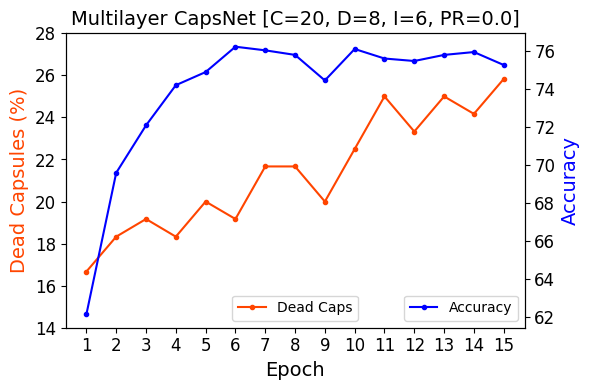

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
xs = np.arange(1, 16)

ax.plot(xs, epoch_dead_capsules_percent, '.-', label='Dead Caps', color='orangered')

ax.set_xticks(xs)
ax.set_ylim(14, 28)
ax.set_xlabel('Epoch', fontsize = 14)
ax.set_ylabel('Dead Capsules (%)', fontsize = 14, color='orangered')
ax.set_title('Multilayer CapsNet [C=20, D=8, I=6, PR=0.0]', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax2 = ax.twinx()

ax2.plot(xs, epoch_accuracies, '.-', label='Accuracy', color='blue')
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('Accuracy', fontsize = 14, color='blue')

ax.legend(fontsize=10, loc='lower center')
ax2.legend(fontsize=10, loc='lower right')
fig.tight_layout()

## Pruned CapsNet [C=20, D=8, I=6] Activations

In [ ]:
def plot_heatmap_intermediate_layers_activations(caps_activations, n_caps_layers, title):
    activation_matrix = []

    for _, layer_activation in caps_activations.items():
        activation_matrix.append(layer_activation.numpy())

    fig, ax = plt.subplots(figsize=(5,2))

    xlabels = np.arange(1, len(activation_matrix[0])+1)
    ylabels = np.arange(1, len(activation_matrix)+1)

    ax = sns.heatmap(activation_matrix, linewidth=0.5, cmap=plt.cm.Greens, annot=False, vmin=0.01, vmax=0.1)

    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels, rotation=0)

    ax.set_xlabel('Capsule')
    ax.set_ylabel('Intermediate Layer')
    ax.set_title(title, fontsize=12)

    plt.show()

In [ ]:
n_inter_caps = 6

unpruned_capsnet_C20_D8_activations = torch.load(TRAIN_DIR+'cifar10/20Caps8Dim/best_multilayer_inter6_capsnet_cifar10_model_convcaps_activations.pth',
                                               map_location=device)
pruned_12pc_capsnet_C20_D8_activations = torch.load(TRAIN_DIR+'cifar10/20Caps8Dim/best_pruned_12pc_multilayer_inter6_capsnet_cifar10_model_convcaps_activations.pth',
                                               map_location=device)
pruned_25pc_capsnet_C20_D8_activations = torch.load(TRAIN_DIR+'cifar10/20Caps8Dim/best_pruned_25pc_multilayer_inter6_capsnet_cifar10_model_convcaps_activations.pth',
                                               map_location=device)
pruned_375pc_capsnet_C20_D8_activations = torch.load(TRAIN_DIR+'cifar10/20Caps8Dim/best_pruned_37pc_multilayer_inter6_capsnet_cifar10_model_convcaps_activations.pth',
                                               map_location=device)

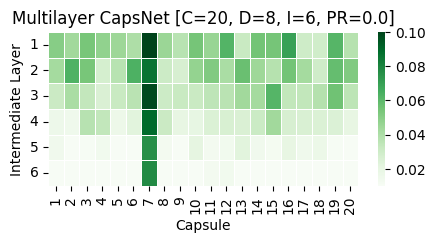

In [ ]:
plot_heatmap_intermediate_layers_activations(unpruned_capsnet_C20_D8_activations,
                                             n_inter_caps,
                                             'Multilayer CapsNet [C=20, D=8, I=6, PR=0.0]')

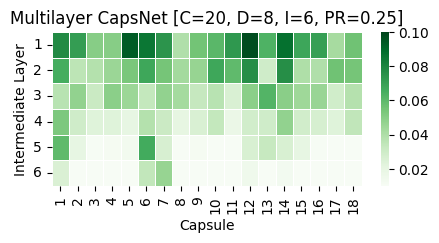

In [ ]:
plot_heatmap_intermediate_layers_activations(pruned_12pc_capsnet_C20_D8_activations,
                                             n_inter_caps,
                                             'Multilayer CapsNet [C=20, D=8, I=6, PR=0.25]')

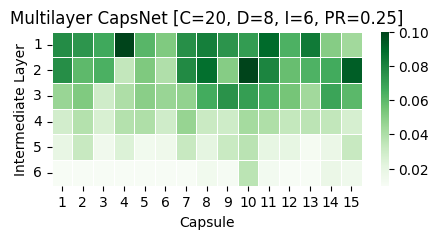

In [ ]:
plot_heatmap_intermediate_layers_activations(pruned_25pc_capsnet_C20_D8_activations,
                                             n_inter_caps,
                                             'Multilayer CapsNet [C=20, D=8, I=6, PR=0.25]')

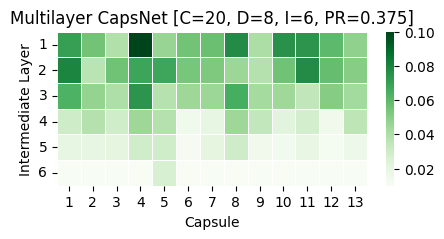

In [ ]:
plot_heatmap_intermediate_layers_activations(pruned_375pc_capsnet_C20_D8_activations,
                                             n_inter_caps,
                                             'Multilayer CapsNet [C=20, D=8, I=6, PR=0.375]')

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+'cifar10/20Caps8Dim/'
n_epochs = 15
inter_layers = 6
plot_title = 'Multilayer CapsNet [C=20, D=8, I=6]'
legends = ['PR = 0.0',
           'PR = 0.125',
           'PR = 0.25',
           'PR = 0.375']

epoch_dead_capsules_percent = np.zeros((4, n_epochs))

for epoch in range(1, n_epochs+1):
    unpruned_epoch_activations = torch.load(CIFAR10_TRAIN_DIR+'trained_multilayer_inter{}_capsnet_cifar10_model_epoch{}_convcaps_activations.pth'.format(inter_layers, epoch),
                                            map_location=device)
    pruned_12pc_epoch_activations = torch.load(CIFAR10_TRAIN_DIR+'trained_pruned_12pc_multilayer_inter{}_capsnet_cifar10_model_epoch{}_convcaps_activations.pth'.format(inter_layers, epoch),
                                          map_location=device)
    pruned_25pc_epoch_activations = torch.load(CIFAR10_TRAIN_DIR+'trained_pruned_25pc_multilayer_inter{}_capsnet_cifar10_model_epoch{}_convcaps_activations.pth'.format(inter_layers, epoch),
                                          map_location=device)
    pruned_37pc_epoch_activations = torch.load(CIFAR10_TRAIN_DIR+'trained_pruned_37pc_multilayer_inter{}_capsnet_cifar10_model_epoch{}_convcaps_activations.pth'.format(inter_layers, epoch),
                                          map_location=device)

    epoch_dead_capsules_percent[0][epoch-1] = utils.count_dead_capsules(unpruned_epoch_activations, 0.01)[-1]
    epoch_dead_capsules_percent[1][epoch-1] = utils.count_dead_capsules(pruned_12pc_epoch_activations, 0.01)[-1]
    epoch_dead_capsules_percent[2][epoch-1] = utils.count_dead_capsules(pruned_25pc_epoch_activations, 0.01)[-1]
    epoch_dead_capsules_percent[3][epoch-1] = utils.count_dead_capsules(pruned_37pc_epoch_activations, 0.01)[-1]

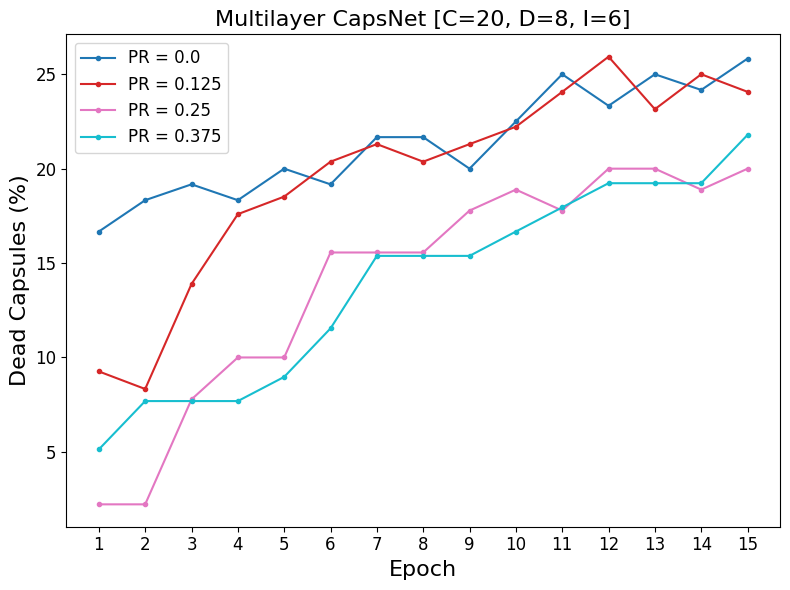

In [ ]:
utils.plot_line_chart(epoch_dead_capsules_percent, legends, 'Epoch', 'Dead Capsules (%)',
                      'Multilayer CapsNet [C=20, D=8, I=6]', marker='.', line='-', grid=False)

## Pruned CapsNet [C=20, D=8, I=7] Activations

In [ ]:
n_inter_caps = 7

unpruned_capsnet_C20_D8_I7_activations = torch.load(TRAIN_DIR+'cifar10/20Caps8Dim/best_multilayer_inter{}_capsnet_cifar10_model_convcaps_activations.pth'.format(n_inter_caps),
                                               map_location=device)
pruned_12pc_capsnet_C20_D8_I7_activations = torch.load(TRAIN_DIR+'cifar10/20Caps8Dim/best_pruned_12pc_multilayer_inter{}_capsnet_cifar10_model_convcaps_activations.pth'.format(n_inter_caps),
                                               map_location=device)
pruned_25pc_capsnet_C20_D8_I7_activations = torch.load(TRAIN_DIR+'cifar10/20Caps8Dim/best_pruned_25pc_multilayer_inter{}_capsnet_cifar10_model_convcaps_activations.pth'.format(n_inter_caps),
                                               map_location=device)
pruned_37pc_capsnet_C20_D8_I7_activations = torch.load(TRAIN_DIR+'cifar10/20Caps8Dim/best_pruned_37pc_multilayer_inter{}_capsnet_cifar10_model_convcaps_activations.pth'.format(n_inter_caps),
                                               map_location=device)

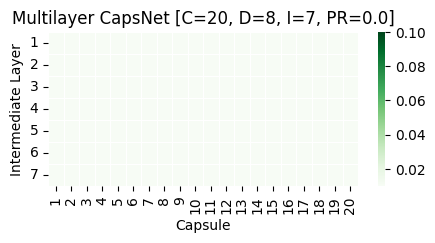

In [ ]:
plot_heatmap_intermediate_layers_activations(unpruned_capsnet_C20_D8_I7_activations,
                                             n_inter_caps,
                                             'Multilayer CapsNet [C=20, D=8, I=7, PR=0.0]')

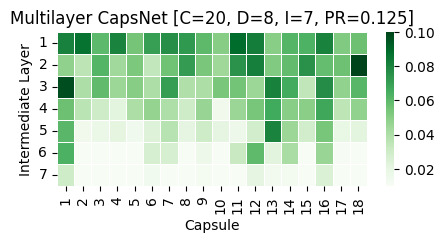

In [ ]:
plot_heatmap_intermediate_layers_activations(pruned_12pc_capsnet_C20_D8_I7_activations,
                                             n_inter_caps,
                                             'Multilayer CapsNet [C=20, D=8, I=7, PR=0.125]')

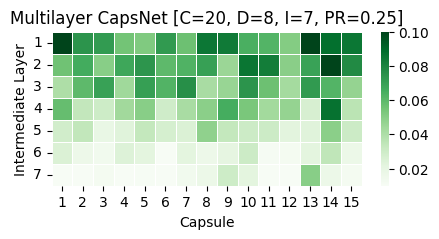

In [ ]:
plot_heatmap_intermediate_layers_activations(pruned_25pc_capsnet_C20_D8_I7_activations,
                                             n_inter_caps,
                                             'Multilayer CapsNet [C=20, D=8, I=7, PR=0.25]')

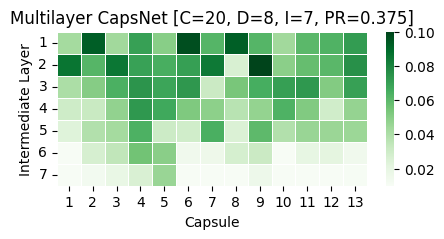

In [ ]:
plot_heatmap_intermediate_layers_activations(pruned_37pc_capsnet_C20_D8_I7_activations,
                                             n_inter_caps,
                                             'Multilayer CapsNet [C=20, D=8, I=7, PR=0.375]')

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+'cifar10/20Caps8Dim/'
n_epochs = 15
inter_layers = 7
plot_title = 'Multilayer CapsNet [C=20, D=8, I=7]'
legends = ['PR = 0.0',
           'PR = 0.125',
           'PR = 0.25',
           'PR = 0.375']

epoch_dead_capsules_percent = np.zeros((4, n_epochs))

for epoch in range(1, n_epochs+1):
    unpruned_epoch_activations = torch.load(CIFAR10_TRAIN_DIR+'trained_multilayer_inter{}_capsnet_cifar10_model_epoch{}_convcaps_activations.pth'.format(inter_layers, epoch),
                                            map_location=device)
    pruned_12pc_epoch_activations = torch.load(CIFAR10_TRAIN_DIR+'trained_pruned_12pc_multilayer_inter{}_capsnet_cifar10_model_epoch{}_convcaps_activations.pth'.format(inter_layers, epoch),
                                          map_location=device)
    pruned_25pc_epoch_activations = torch.load(CIFAR10_TRAIN_DIR+'trained_pruned_25pc_multilayer_inter{}_capsnet_cifar10_model_epoch{}_convcaps_activations.pth'.format(inter_layers, epoch),
                                          map_location=device)
    pruned_37pc_epoch_activations = torch.load(CIFAR10_TRAIN_DIR+'trained_pruned_37pc_multilayer_inter{}_capsnet_cifar10_model_epoch{}_convcaps_activations.pth'.format(inter_layers, epoch),
                                          map_location=device)

    epoch_dead_capsules_percent[0][epoch-1] = utils.count_dead_capsules(unpruned_epoch_activations, 0.01)[-1]
    epoch_dead_capsules_percent[1][epoch-1] = utils.count_dead_capsules(pruned_12pc_epoch_activations, 0.01)[-1]
    epoch_dead_capsules_percent[2][epoch-1] = utils.count_dead_capsules(pruned_25pc_epoch_activations, 0.01)[-1]
    epoch_dead_capsules_percent[3][epoch-1] = utils.count_dead_capsules(pruned_37pc_epoch_activations, 0.01)[-1]

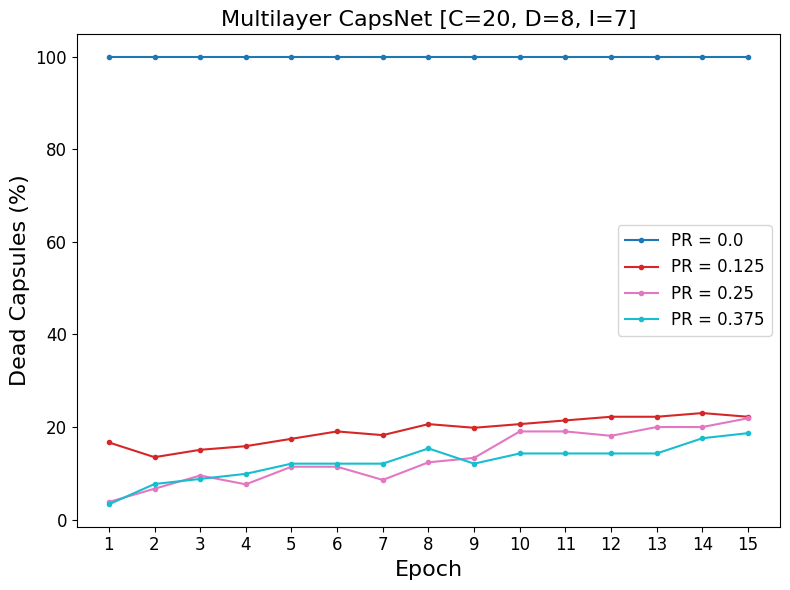

In [ ]:
utils.plot_line_chart(epoch_dead_capsules_percent, legends, 'Epoch', 'Dead Capsules (%)',
                      plot_title, marker='.', line='-', grid=False)

## Accuracy plots of CapsNet[C=20, D=8] intermediate layers for different pruning ratios

In [14]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+'cifar10/20Caps8Dim/'

capsnet_accuracies = np.zeros((8, 4))

inter_caps_layer = 6

unpruned_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                        map_location=device)
pruned_12pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_12pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)
pruned_25pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_25pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)
pruned_37pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_37pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)

capsnet_accuracies[0] = np.array([unpruned_capsnet_model['best_top1'],
                                    pruned_12pc_capsnet_model['best_top1'],
                                    pruned_25pc_capsnet_model['best_top1'],
                                    pruned_37pc_capsnet_model['best_top1']])

In [15]:
inter_caps_layer = 7

unpruned_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                        map_location=device)
pruned_12pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_12pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)
pruned_25pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_25pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)
pruned_37pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_37pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)

capsnet_accuracies[1] = np.array([unpruned_capsnet_model['best_top1'],
                                    pruned_12pc_capsnet_model['best_top1'],
                                    pruned_25pc_capsnet_model['best_top1'],
                                    pruned_37pc_capsnet_model['best_top1']])

In [16]:
inter_caps_layer = 8

unpruned_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                        map_location=device)
pruned_25pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_25pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)
pruned_37pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_37pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)

capsnet_accuracies[2] = np.array([unpruned_capsnet_model['best_top1'],
                                    10.00,
                                    pruned_25pc_capsnet_model['best_top1'],
                                    pruned_37pc_capsnet_model['best_top1']])

In [17]:
inter_caps_layer = 9

unpruned_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                        map_location=device)
pruned_25pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_25pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)
pruned_37pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_37pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)

capsnet_accuracies[3] = np.array([unpruned_capsnet_model['best_top1'],
                                    10.00,
                                    pruned_25pc_capsnet_model['best_top1'],
                                    pruned_37pc_capsnet_model['best_top1']])

In [18]:
inter_caps_layer = 10

unpruned_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                        map_location=device)
pruned_37pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_37pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)

capsnet_accuracies[4] = np.array([unpruned_capsnet_model['best_top1'],
                                  10.00,
                                  10.00,
                                  pruned_37pc_capsnet_model['best_top1']])

In [19]:
inter_caps_layer = 11

pruned_37pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_37pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)

capsnet_accuracies[5] = np.array([10.00,
                                  10.00,
                                  10.00,
                                  pruned_37pc_capsnet_model['best_top1']])

In [20]:
inter_caps_layer = 12

pruned_37pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_37pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)

capsnet_accuracies[6] = np.array([10.00,
                                  10.00,
                                  10.00,
                                  pruned_37pc_capsnet_model['best_top1']])

In [22]:
inter_caps_layer = 13

pruned_37pc_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_pruned_37pc_multilayer_inter{}_capsnet_cifar10_model.pt'.format(inter_caps_layer),
                                            map_location=device)

capsnet_accuracies[7] = np.array([10.00,
                                  10.00,
                                  10.00,
                                  10.00])

In [23]:
capsnet_accuracies = capsnet_accuracies.T

print(capsnet_accuracies)

[[76.2  10.   10.   10.   10.   10.   10.   10.  ]
 [78.93 79.29 10.   10.   10.   10.   10.   10.  ]
 [79.5  79.6  80.04 79.12 10.   10.   10.   10.  ]
 [78.97 79.2  79.01 79.08 79.26 79.13 79.21 10.  ]]


In [38]:
def plot_line_chart(arrs, legends, xlabel, ylabel, title, xticks=[], marker='o', line='-', color_map = plt.cm.tab10, grid=True):
    fig, ax = plt.subplots(figsize=(8, 5))

    if len(xticks) == 0:
        xticks = np.arange(1, len(arrs[0])+1)

    colors = color_map(np.linspace(0, 1, len(legends)))

    for i in range(len(arrs)):
        ax.plot(xticks, arrs[i], marker+line, linewidth=2, label = legends[i], color=colors[i])

    ax.set_xticks(xticks)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_ylim(bottom=-30, top=100)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_title(title, fontsize = 16)
    ax.legend(loc='lower left',fontsize = 11)
    if grid:
        plt.grid(color = 'green', linestyle = '--', linewidth = 0.25)
    fig.tight_layout()

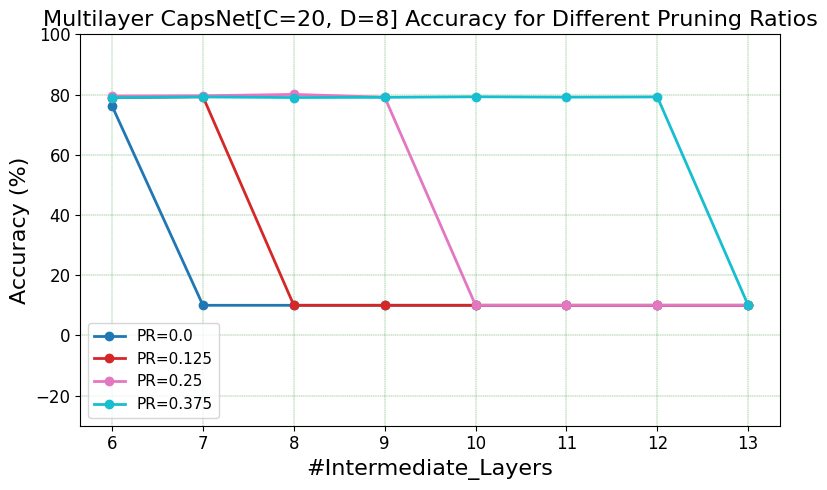

In [39]:
legends = ['PR=0.0', 'PR=0.125', 'PR=0.25', 'PR=0.375']
plot_title = 'Multilayer CapsNet[C=20, D=8] Accuracy for Different Pruning Ratios'

plot_line_chart(capsnet_accuracies, legends, '#Intermediate_Layers', 'Accuracy (%)',
                      plot_title, [6, 7, 8, 9, 10, 11, 12, 13], marker='o', line='-', color_map = plt.cm.tab10)